## Exercise 1

**Task:** *Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?*

In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import notebook

RANDOM_SEED = 30

%matplotlib inline
sns.set_theme()

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10] #slicing the first 10 indexes of the list

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
print(f"Number of names: {len(words):,}")

Number of names: 32,033


In [4]:
# Retrieving a set of unique letters
chars = sorted(list(set(''.join(words))))

# Creating a mapping from a letter to an id
char2id = {s: i+1 for i, s in enumerate(chars)}
# Adding the start_of_word/end_of_word token => "."
char2id['.'] = 0

# Creating a mapping from an id to letter
id2char = {i: s for s, i in char2id.items()}

In [5]:
char2id

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [6]:
id2char

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Biagram Model

In [7]:
# Creating the dataset

X_bigram, Y_bigram = [], []

for word in words:
    # Adding special token for the start and end of each word
    chars = ['.'] + list(word) + ['.']
    for char_1, char_2 in zip(chars, chars[1:]):
        # Getting the indices of a letter
        index_1 = char2id[char_1]
        index_2 = char2id[char_2]
        
        # Adding letter indices to lists
        X_bigram.append(index_1)
        Y_bigram.append(index_2)
    
# Changing them to PyTorch tensors
X_bigram = torch.tensor(X_bigram)
Y_bigram = torch.tensor(Y_bigram)

In [8]:
print(X_bigram)
print(Y_bigram)

tensor([ 0,  5, 13,  ..., 25, 26, 24])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


Now, we have a dataset where we know the next letter based on the previous one. 

In [9]:
class BigramModel:
    def __init__(
        self, 
        num_features, 
        num_outputs, 
        num_epochs, 
        learning_rate,
        logging=False,
        regularize=False, 
        smooth_strength=None, 
        seed=2147483647,
        enable_tqdm=True,
        *args,
        **kwargs,
    ):
        """Initializes BigramModel instance."""
        # Creating class attributes
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.logging = logging
        self.regularize = regularize
        self.smooth_strength = smooth_strength
        self.seed = seed
        self.enable_tqdm = enable_tqdm
        # Generating random weights based on a random seed
        generator = torch.Generator().manual_seed(self.seed)
        self.weights = torch.randn((self.num_features, self.num_outputs), generator=generator)
        self.weights.requires_grad = True
        
    def __call__(self, x, y):
        """Makes a softmax forward pass and computes the NLL loss."""
        # One-hot encoding NN inputs
        x_encoded = F.one_hot(x, num_classes=self.num_outputs).float()
        # Computing predictions for log-counts
        logits = x_encoded @ self.weights
        # Retrieving counts
        counts = logits.exp()
        # Computing probabilities for the next character
        probas = counts / counts.sum(1, keepdims=True)
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss
    
    def fit(self, x, y):
        """Fits the NN to data."""
        # Preallocating a dict for storing loss across epochs
        loss_per_epoch = {}
        # Utilizing a progress bar when training or not
        epoch_counter = notebook.tqdm(range(self.num_epochs)) if self.enable_tqdm else range(self.num_epochs)
        for k in epoch_counter:
            # Making a forward pass and computing a loss
            loss = self(x, y)
            # Adding a loss computed to the history
            loss_per_epoch[f"epoch_{k+1}"] = loss.item()
            # Logging progress
            if self.logging:
                print(f"Epoch {k + 1:03d}/{self.num_epochs:03d}: loss = {loss.item():.4f}")
            
            # Setting gradients to zero
            self.weights.grad = None
            # Making a backward pass (initiating backpropagation)
            loss.backward()
            
            # Updating weights (SGD)
            self.weights.data -= self.learning_rate * self.weights.grad
        
        # Creating an attribute for training history after training
        self.history = loss_per_epoch
    
    def generate_sample(self, num_examples, id2char):
        """Generates a sample with names from the NN."""
        generator = torch.Generator().manual_seed(self.seed)
        # Preallocating a list for storing generated names
        generated_names = []
        for i in range(num_examples):
            # Preallocating a list for storing letters
            out = []
            # Starting names generation with "."
            ix = 0
            while True:
                # Computing probabilities for the next character
                x_encoded = F.one_hot(torch.tensor([ix]), num_classes=self.num_outputs).float()
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                # Retrieving a letter index from the probability distribution
                ix = torch.multinomial(
                    probas, num_samples=1, replacement=True, generator=generator
                ).item()
                # Adding the letter to a list
                out.append(id2char[ix])
                # Iterating until "." is encountered
                if ix == 0:
                    break
            
            # Joining letters together to compose a word and add to other examples
            generated_names.append(''.join(out)[:-1])
        
        return generated_names

In [10]:
# Instantiating a bigram model
bigram_model = BigramModel(
    num_features=27, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
bigram_model.fit(X_bigram, Y_bigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
bigram_model.generate_sample(num_examples=10, id2char=id2char)

['junide',
 'janasah',
 'p',
 'cfay',
 'a',
 'nn',
 'kohin',
 'tolian',
 'juwe',
 'kalanaauranilevias']

## Trigram Model

Lets create a dataset that takes the first two characters as the input and uses that information to predict the third character

In [12]:
X_trigram, Y_trigram = [], []
for word in words:
    # Adding special token for each word
    chars = ['.'] + list(word) + ['.']
    for char_1, char_2, char_3 in zip(chars, chars[1:], chars[2:]):
        # Getting the indices of a letter
        index_1 = char2id[char_1]
        index_2 = char2id[char_2]
        index_3 = char2id[char_3]
        
        # Adding letter indices to lists
        X_trigram.append([index_1, index_2])
        Y_trigram.append(index_3)

# Casting as PyTorch tensors
X_trigram = torch.tensor(X_trigram)
Y_trigram = torch.tensor(Y_trigram)

In [13]:
print(X_trigram)
print(Y_trigram)

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        ...,
        [26, 25],
        [25, 26],
        [26, 24]])
tensor([13, 13,  1,  ..., 26, 24,  0])


In [14]:
class TrigramModel(BigramModel):
    def __init__(self, *args, **kwargs):
        """Inherits initialization schema from BigramModel class."""
        super().__init__(*args, **kwargs)
    
    def __call__(self, x, y):
        """Makes a softmax forward pass and computes the NLL loss."""
        x_encoded = F.one_hot(x, num_classes=self.num_outputs).float().view(-1, self.num_features)
        logits = x_encoded @ self.weights # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        probas = counts / counts.sum(1, keepdims=True) # probabilities for next character
        
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect.")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss
    
    def generate_sample(self, num_examples, id2char):
        """Generates a sample with names from the NN."""
        generator = torch.Generator().manual_seed(self.seed)
        generated_names = []
        for i in range(num_examples):
            out = []
            # Initializing the starting sequence
            context = [0, 0] 
            while True:
                x_encoded = F.one_hot(torch.tensor([context]), num_classes=self.num_outputs).float().view(1, -1)
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                
                ix = torch.multinomial(
                    probas, num_samples=1, replacement=True, generator=generator
                ).item()
                # Adding the predicted character and shifting
                context = context[1:] + [ix]
                out.append(id2char[ix])
                if ix == 0:
                    break
                    
            generated_names.append(''.join(out)[:-1])
        
        return generated_names

In [15]:
# Instantiating a trigram model
trigram_model = TrigramModel(
    num_features=54, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
trigram_model.fit(X_trigram, Y_trigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
trigram_model.generate_sample(num_examples=10, id2char=id2char)

['aunide',
 'aliasad',
 'ushfay',
 'ainn',
 'aui',
 'ritoleras',
 'get',
 'usannaauranileniassibdainrwi',
 'ol',
 'seisiely']

### Comparison

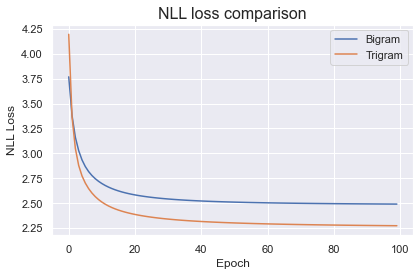

In [17]:
# Losses obtained during training bigram/trigram models
loss_histories = {
    "Bigram": bigram_model.history.values(),
    "Trigram": trigram_model.history.values(),
}

# Joining results in a DataFrame
comparison_df = pd.DataFrame(loss_histories)

# Plotting the comparison
comparison_df.plot()
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("NLL loss comparison", fontsize=16)
plt.tight_layout()
plt.show()